In [1]:
import numpy as np
import random

In [2]:
def add_in_news_sites(num_news_sites,fake_news_sites, total_network, number_of_people):
    '''This function adds the news sites into the network graph
    
    Parameters:
    ----------
    num_news_sites: the number of news sites in our network
    fake_news_sites: the number of fake news sites in our network
    total_network: the current matrix network (with just people)
    number_of_people: number of nodes in facebook graph
    
    Returns:
    --------
    total_network: network with fake news sites added
    news_sites_indices: indices in the total_network of the news sites
    news_sites_indices_political: array which specifies 0 (Democrat) or 1 (Republican) for each index in news_sites_indices
    fake_news_sites_indices: indices in the total_network of the fake news sites
    fake_news_sites_indices_political: array which specifies 0 (Democrat) or 1 (Republican) for each index in fake_news_sites_indices

    For example, if news_sites_indices = [233, 455, 600] and news_sites_indices_political = [0,1,1] then the news sites
    at indices 455 and 600 are republican news sites and the news site at index 233 is democratic.
    '''
    
    #3: Add in news sites and fake news sites
    n = 4039
    news_sites_indices = []
    for i in range(num_news_sites):
        news_sites_indices.append(number_of_people+i)
        total_network = np.append(total_network,[[0]]*n,axis = 1)
        total_network = np.append(total_network,[[0]*(n+1)],axis = 0)
        n += 1

    news_sites_indices_political = np.random.choice(2,num_news_sites,replace = True)

    fake_news_sites_indices = []
    for i in range(fake_news_sites):
        fake_news_sites_indices.append(news_sites_indices[-1]+1+i)
        total_network = np.append(total_network,[[0]]*n,axis = 1)
        total_network = np.append(total_network,[[0]*(n+1)],axis = 0)
        n += 1

    fake_news_sites_indices_political = np.random.choice(2,fake_news_sites,replace = True)
    
    for i in news_sites_indices:
        total_network[i,i] = 1
        
    for i in fake_news_sites_indices:
        total_network[i,i] = 1
    
    return total_network, news_sites_indices, news_sites_indices_political, fake_news_sites_indices, fake_news_sites_indices_political

In [3]:
def assign_W_weights(A_matrix, W_matrix, weight_for_significant_others,weight_given_to_news_sources,number_news_connections,number_of_people, democrats, republicans, news_sites_indices, news_sites_indices_political, fake_news_sites_indices, fake_news_sites_indices_political):
    """ This function constructs the W matrix and checks the condition that rows sum to 1 
    
    Parameters:
    -----------
    total_network: network of people/news sites
    weight_for_significant_others: % of weight given to significant others
    weight_given_to_news_sources: % of weight given to news source
    number_news_connections: number of news sites that each person is connected to
    number_of_people: number of people in network
    democrats: indicies of democratic people
    republicans: indices of republican people
    news_sites_indices: indices of news sites
    news_sites_indices_political: array which specifies 0 (Democrat) or 1 (Republican) for each index in news_sites_indices
    fake_news_sites_indices: indices of fake news sites
    fake_news_sites_indices_political: array which specifies 0 (Democrat) or 1 (Republican) for each index in fake_news_sites_indices
    
    Returns:
    --------
    W_matrix: final weight matrix
    """

    for i in range(number_of_people):
        connections = list(np.nonzero(W_matrix[i,:] != 0)[0])
        num_connections = len(connections)
        num_news = range(len(news_sites_indices))
        num_fake_news = range(len(fake_news_sites_indices))
        
        W_matrix[i,i] = 1-A_matrix[i,i]
        total_weight_to_give = A_matrix[i,i]
        weight_given = W_matrix[i,i]
        
        if i in democrats:
            my_news = [news_sites_indices[i] for i in num_news if news_sites_indices_political[i] == 0]
            my_fake_news = [fake_news_sites_indices[i] for i in num_fake_news if fake_news_sites_indices_political[i] == 0]
            all_news = np.append(my_fake_news,my_news)
            try:
                news_connections = [all_news[i] for i in np.random.choice(list(range(len(all_news))),number_news_connections,replace = False)]
            except:
                news_connections = all_news
                
        elif i in republicans:
            my_news = [news_sites_indices[i] for i in num_news if news_sites_indices_political[i] == 1]
            my_fake_news = [fake_news_sites_indices[i] for i in num_fake_news if fake_news_sites_indices_political[i] == 1]
            all_news = np.append(my_fake_news,my_news)
            try:
                news_connections = [all_news[i] for i in np.random.choice(list(range(len(all_news))),number_news_connections,replace = False)]
            except:
                news_connections = all_news
                
        for a in news_connections:
            W_matrix[i,int(a)] = weight_given_to_news_sources*total_weight_to_give
            weight_given += weight_given_to_news_sources*(total_weight_to_give)
        
        if num_connections <= 2:
            weight_left = 1 - weight_given

            a = [random.random() for i in range(num_connections)]
            b = [weight_left*aa/float(sum(a)) for aa in a]
            
            for aa in range(len(b)):
                W_matrix[i,connections[aa]] = b[aa]
            W_matrix[i,connections[aa]] = b[aa]-10**(-12)
        
        elif num_connections > 2:
            signif_others = [connections[i] for i in np.random.choice(list(range(num_connections)),2,replace = False)]
            con = [c for c in connections if c not in signif_others]
            for j in signif_others:
                W_matrix[i,j] = weight_for_significant_others*total_weight_to_give
                weight_given += weight_for_significant_others*total_weight_to_give
                
            weight_left = 1 - weight_given
            
            a = [random.random() for i in range(len(con))]
            b = [weight_left*aa/float(sum(a)) for aa in a]
            for aa in range(len(con)):
                W_matrix[i,con[aa]] = b[aa]
            W_matrix[i,con[aa]] = b[aa]-10**(-12)
          
    return W_matrix


In [4]:
def check_W(W_matrix):
    #check that each row sums to 1 
    for i in range(W_matrix.shape[0]):
        row_weight = np.sum(W_matrix, axis=1)[i]
        try:
            assert (row_weight <= 1.0) 
        except:
            print("larger than 1",row_weight)
            
        try:
            assert (row_weight >= 0)
        except:
            print("Smaller than 0",row_weight)
            
        try:
            assert round(row_weight,2) == 1.0
        except:
            print("Not 1",round(row_weight,2))
        

def check_A(A_matrix):
    for i in range(A_matrix.shape[0]):
        if i < 4039: # if a person
            assert A_matrix[i,i] >= 0 and A_matrix[i,i] <= 1
        else:
            assert A_matrix[i,i] == 0
            
def check_X0(X0_matrix):
    for i in range(len(X0_matrix)):
        try:
            assert X0_matrix[i][0] >= 0 and X0_matrix[i][0] <= 1.0
        except:
            print(i,X0_matrix[i][0])

In [5]:
def construct_W_matrix(A_matrix, total_network,num_news_sites,fake_news_sites,weight_for_significant_others,weight_given_to_news_sources,number_news_connections):
    """Driver function for constructing W matrix
    
    Parameters:
    -----------
    num_news_sites: number of news sites to include in network
    fake_news_sites: number of fake news sites to include in network
    weight_for_significant_others: percentage weight to give to significant others
    weight_given_to_news_sources: percentage weight to give to news sources
    number_news_connections: number of news sources each person is connected to 
    
    Returns:
    -------
    W_matrix: W matrix
    news_info: List of tuples (a,b) where a is index of news site and b is political leaning of news site (0 or 1)
    fake_news_info: List of tuples (a,b) where a is index of fake news site and b is political leaning of fake news site (0 or 1)
    democrats: indices of democratic people
    republicans: indices of republican people
    """
        
    #2: Split people into Republican or Democrat (Independents split evenly between the two groups)
    #40.9% call themselves liberal, 28.4% moderate, and 30.7% call themselves conservative 
    parties = list(range(number_of_people))
    np.random.shuffle(parties)
    democrats = parties[:int(len(parties)*(0.409+0.142))]
    republicans = parties[int(len(parties)*(0.409+0.142)):]
    
    total_network, news_sites_indices, news_sites_indices_political, fake_news_sites_indices, fake_news_sites_indices_political = add_in_news_sites( num_news_sites,fake_news_sites, total_network,number_of_people)
    W_matrix = assign_W_weights(A_matrix, total_network, weight_for_significant_others,weight_given_to_news_sources,number_news_connections, number_of_people, democrats, republicans,news_sites_indices, news_sites_indices_political, fake_news_sites_indices, fake_news_sites_indices_political)
    
    news_info = list(zip(news_sites_indices,news_sites_indices_political))
    fake_news_info = list(zip(fake_news_sites_indices,fake_news_sites_indices_political))
    
    return W_matrix, news_info, fake_news_info, democrats, republicans 

In [6]:
def construct_A_matrix(num_news,num_fake_news):
    n = 4039
    A_matrix = np.zeros([n+num_news+num_fake_news,n+num_news+num_fake_news])
    for i in range(n):
        A_matrix[i,i] = random.random()
    for i in range(n,A_matrix.shape[0]):
        A_matrix[i,i] = 0
    return A_matrix


In [7]:
def construct_X0_matrix(news_sites, fake_news_sites, democrats, republicans):
    """Initial Belief Matrix for statement: Abortion should be legal in all/most cases
    
    News sources:
    -news sources are assigned belief based on their political leaning
    -random value in [0,0.5] for republicans
    -random value in [0.5,1] for democrats
    
    Fake news sources:
    -fake news sources are assigned belief based on their political leaning but assigned EXTREME beliefs
    -random value in [0,0.1] for republicans
    -random value in [0.9,1] for democrats
    
    People:
    -54% of moderates are assigned random value in [0.5,1], rest are assigned random value in [0,0.5]
    -66% of democrats are assigned random value in [0.5,1], rest are assigned random value in [0,0.5]
    -36% of republicans are assigned random value in [0.5,1], rest are assigned random value in [0,0.5]
    """
    X_matrix = np.zeros([4039+len(news_sites)+len(fake_news_sites),1])

    #1: deal with news sites
    for i in news_sites:
        if i[1] == 0: #if democrat
            X_matrix[i[0]] = 0.5*np.random.random()+0.5
        elif i[1] == 1:
            X_matrix[i[0]] = 0.5*np.random.random()
            
    #2: deal with fake news sites
    for i in fake_news_sites:
        if i[1] == 0: #if democrat then in [0.9,1]
            X_matrix[i[0]] = 0.1*np.random.random()+0.9
        elif i[1] == 1: #if republican, then in [0,0.1]
            X_matrix[i[0]] = 0.1*np.random.random()
            
    #3: deal with people
    all_ppl = len(democrats)+len(republicans)
    independent_dems = democrats[:int(all_ppl*0.142)]
    true_dems = [i for i in democrats if i not in independent_dems]
    independent_repub = republicans[:int(all_ppl*0.142)]
    true_repubs = [i for i in republicans if i not in independent_repub]
    
    #if democrat, 66% support [0.5,1]
    support_dems = true_dems[:int(len(true_dems)*0.66)]
    for i in true_dems:
        if i in support_dems:
            X_matrix[i] = 0.5*np.random.random()+0.5
        else:
            X_matrix[i] = 0.5*np.random.random()
         
    #if republican, 36% support
    support_repub = true_repubs[:int(len(true_repubs)*0.36)]
    for i in true_repubs:
        if i in support_repub:
            X_matrix[i] = 0.5*np.random.random()+0.5
        else:
            X_matrix[i] = 0.5*np.random.random()
                     
    #if moderate, 54% support
    independents = independent_dems + independent_repub
    support_ind = independents[:int(len(independents)*0.54)]
    for i in independents:
        if i in support_ind:
            X_matrix[i] = 0.5*np.random.random()+0.5
        else:
            X_matrix[i] = 0.5*np.random.random()
        
    for i in range(len(X_matrix)):
        if not (X_matrix[i][0] >= 0 and X_matrix[i][0] <= 1.0):
            print("X0",i,X_matrix[i][0])  
        
    print(len(independents)+len(true_repubs)+len(true_dems))
    
    return X_matrix

In [8]:
# Constructing the new X matrix
def update_beliefs(A_matrix, W_matrix, x_current, X_0):
    first_two = np.dot(A_matrix,W_matrix)
    second_two = np.dot(first_two, x_current)
    I = np.eye((A_matrix).shape[0])
    next_x = np.add(second_two,np.dot(np.subtract(I,A_matrix),X_0))
    return next_x

_________________
# Simulation Driver

In [9]:
#1: Initial set-up
number_of_people = 4039
total_network = np.zeros([number_of_people,number_of_people])

fb_connections = np.loadtxt('facebook_combined.txt', delimiter = " ")
for i in fb_connections:
    total_network[int(i[0]),int(i[1])] = 1.0
    total_network[int(i[1]),int(i[0])] = 1.0

In [10]:
def initiate_matrices(num_news, num_fake_news, weight_for_significant_others, weight_given_to_news_sources, number_news_connections):
    #######Parameters#########
    num_news = 7
    num_fake_news = 8
    weight_for_significant_others = 0.2
    weight_given_to_news_sources = 0.1
    number_news_connections = 4
    ###########################
    A_matrix = construct_A_matrix(num_news,num_fake_news)
    W_matrix, news_sites, fake_news_sites, democrats, republicans = construct_W_matrix(A_matrix,total_network,num_news,num_fake_news,weight_for_significant_others,weight_given_to_news_sources,number_news_connections)
    X_matrix = construct_X0_matrix(news_sites, fake_news_sites, democrats, republicans)
    
    return W_matrix, A_matrix, X_matrix

In [12]:
import csv 
with open('W_matrix.csv', 'w') as f:
    writer = csv.writer(f)
    for i in W:
        row = []
        for j in i:
            row.append(j)
        writer.writerow(row)
        
with open('A_matrix.csv', 'w') as f:
    writer = csv.writer(f)
    for i in A:
        row = []
        for j in i:
            row.append(j)
        writer.writerow(row)
        
with open('X_matrix.csv', 'w') as f:
    writer = csv.writer(f)
    for i in X:
        row = []
        for j in i:
            row.append(j)
        writer.writerow(row)

In [ ]:
#######Parameters#########
num_news = 7
num_fake_news = 8
weight_for_significant_others = 0.2
weight_given_to_news_sources = 0.5
number_news_connections = 4
###########################

tol = 0.01 # change the tolerance if needed for convergence

for num_fake_news in [0,40]:#[0,10,20,30,40]:
    for num_news in [1,25]:#[1,6,11,16,21,25]:
        for weight_for_significant_others in [0.1,0.4]:#[0,0.10,0.20,0.30,0.40]:
            for num_news_connections in [1,9]:#[1,3,5,7,9]:
                weight_given_to_news_sources = (0.8-2*weight_for_significant_others)/float(num_news_connections)

                count = 0
                W, A, X = initiate_matrices(num_news, num_fake_news, weight_for_significant_others, weight_given_to_news_sources, number_news_connections)
                print("A",A.shape)
                print("W",W.shape)
                print("X",X.shape)
                #####Check###
                check_W(W)
                check_A(A)
                check_X0(X)
                ############
                
                X0 = X[:,:]
                X_new = update_beliefs(A, W, X, X0)

                belief_results =  [X0, X_new]

                while np.linalg.norm(np.subtract(X,X_new)) > tol:
                    X = X_new
                    count += 1
                    X_new = update_beliefs(A, W, X, X0)
                    flag = False
                    for i in X_new:
                        if i[0] > 1.0 or i[0] < 0:
                            print("Problem")
                            flag = True
                    if flag:
                        print("A now",A.shape)
                        print("W now",W.shape)
                        print("X now",X.shape)
                        name = str(num_fake_news)+"_"+str(num_news)+"_"+str(weight_for_significant_others)+"_"+str(num_news_connections)                

                        with open(name+'.csv', 'w') as f:
                            writer = csv.writer(f)
                            for i in belief_results:
                                writer.writerow(i)
                                
                                
                        with open('W_matrix_prob2.csv', 'w') as f:
                            writer = csv.writer(f)
                            for i in W:
                                row = []
                                for j in i:
                                    row.append(j)
                                writer.writerow(row)

                        with open('A_matrix_prob2.csv', 'w') as f:
                            writer = csv.writer(f)
                            for i in A:
                                row = []
                                for j in i:
                                    row.append(j)
                                writer.writerow(row)

                        with open('X_matrix_prob2.csv', 'w') as f:
                            writer = csv.writer(f)
                            for i in X0:
                                row = []
                                for j in i:
                                    row.append(j)
                                writer.writerow(row)
                    belief_results.append(X_new)
                    
                
                        
                print(count)

#compare old and new beliefs
#for i in range(len(X_new)):    
#    print(X[i],X_new[i])
    

4039
A (4054, 4054)
W (4054, 4054)
X (4054, 1)


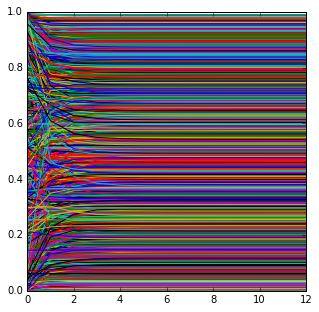

In [159]:
ppl = []
for p in range(4039):
    person = []
    for m in range(len(belief_results)):
        person.append(belief_results[m][p])
    ppl.append(person)
    
import matplotlib.pyplot as plt
%matplotlib inline  
plt.figure(figsize=(5,5))

for i in range(len(ppl)):
    plt.plot(ppl[i])

In [17]:
for num_fake_news in [0,40]:#[0,10,20,30,40]:
    for num_news in [1,25]:#[1,6,11,16,21,25]:
        for weight_for_significant_others in [0.1,0.4]:#[0,0.10,0.20,0.30,0.40]:
            for num_news_connections in [1,9]:#[1,3,5,7,9]:
                weight_given_to_news_sources = (0.8-2*weight_for_significant_others)/float(num_news_connections)

                W, A, X = initiate_matrices(num_news, num_fake_news, weight_for_significant_others, weight_given_to_news_sources, number_news_connections)

                #####Check###
                check_W(W)
                check_A(A)
                check_X0(X)
                ############

4039
4039
4039
4039
4039
4039
4039
4039
4039
4039


KeyboardInterrupt: 

In [21]:
all_news = [1]
number_news_connections = 1 

news_connections = [all_news[i] for i in np.random.choice(list(range(len(all_news))),number_news_connections,replace = False)]

